# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [23]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats
from matplotlib.ticker import PercentFormatter
from sklearn.cluster import DBSCAN

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [3]:
# loading the data:
customers = pd.read_csv('../Wholesale customers data.csv')
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [4]:
customers.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [5]:
customers.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

In [6]:
customers.isna().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

/home/rafa/.local/lib/python3.5/site-packages/pandas/core/computation/check.py:19: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.6.1

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


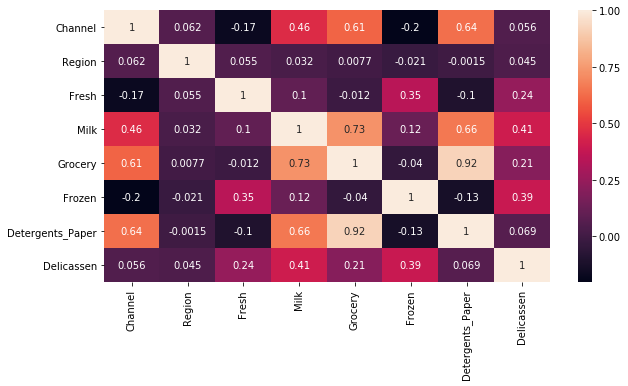

In [7]:
fig, ax = plt.subplots(figsize=(10,5)) 
sb.heatmap(customers.corr(), annot=True, ax=ax)

In [8]:
# Your code here:
pareto_df=customers[['Fresh','Milk','Grocery','Frozen', 'Detergents_Paper','Delicassen']]
pareto_df['Custom_sum']=pareto_df.sum(axis=1)
pareto_df.head()

/home/rafa/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Custom_sum
0,12669,9656,7561,214,2674,1338,34112
1,7057,9810,9568,1762,3293,1776,33266
2,6353,8808,7684,2405,3516,7844,36610
3,13265,1196,4221,6404,507,1788,27381
4,22615,5410,7198,3915,1777,5185,46100


In [9]:
int(customers.shape[0]*0.2)

88

In [11]:
customers_20percent=pareto_df.shape[0]*0.2  
pareto_df.sort_values('Custom_sum', ascending=False)
pareto_df[:88].Custom_sum.sum()/pareto_df.Custom_sum.sum()

0.2617965046684223

### 88 customers suponen el 20% del total de customers. No se cumple el principio de Pareto

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [12]:
# Your code here
for i in customers:
    customers=customers[np.abs(customers[i]-customers[i].mean()) <= (3*customers[i].std())]
customers.shape

(396, 8)

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [18]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:
scaler = StandardScaler()
scaler.fit(customers)
customers_scales=scaler.transform(customers)
customers_scales

array([[ 1.57279503,  0.58093719,  0.18220867, ..., -0.81440626,
         0.27020842,  0.14949474],
       [ 1.57279503,  0.58093719, -0.3854514 , ..., -0.27553005,
         0.5160899 ,  0.5547138 ],
       [-0.63581076,  0.58093719,  0.24249473, ...,  1.34040236,
        -0.59057536,  0.56581569],
       ...,
       [-0.63581076,  0.58093719,  2.86868118, ...,  0.68107966,
        -0.75502598,  1.08205368],
       [-0.63581076,  0.58093719, -0.05842984, ..., -0.5275626 ,
        -0.7252342 ,  0.87759383],
       [-0.63581076,  0.58093719, -0.81736667, ..., -0.86627484,
        -0.60249207, -1.04025805]])

# Challenge 3 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [19]:
# Your code here:
kmeans = KMeans(n_clusters=3, random_state=0).fit(customers_scales)
customers['Labels']=kmeans.labels_

Count the values in `labels`.

In [20]:
# Your code here:
customers.Labels.value_counts()

1    205
2    109
0     82
Name: Labels, dtype: int64

In [21]:
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Labels
0,2,3,12669,9656,7561,214,2674,1338,2
1,2,3,7057,9810,9568,1762,3293,1776,2
3,1,3,13265,1196,4221,6404,507,1788,0
4,2,3,22615,5410,7198,3915,1777,5185,0
5,2,3,9413,8259,5126,666,1795,1451,2


# Challenge 4 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [24]:
# Your code here
clustering = DBSCAN(eps=0.5).fit(customers_scales)
customers['labels_DBSCAN']=clustering.labels_

Count the values in `labels_DBSCAN`.

In [25]:
# Your code here
customers['labels_DBSCAN'].value_counts()

-1    332
 0     55
 1      5
 2      4
Name: labels_DBSCAN, dtype: int64

# Challenge 5 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

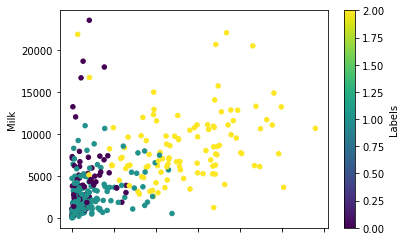

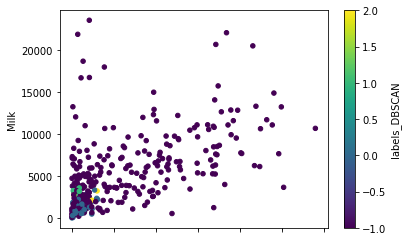

In [26]:
# Your code here:
customers.plot.scatter(x='Detergents_Paper', y='Milk', c='Labels',colormap='viridis')
customers.plot.scatter(x='Detergents_Paper', y='Milk', c='labels_DBSCAN',colormap='viridis')

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

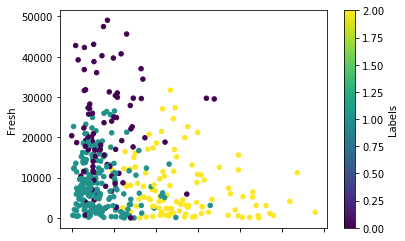

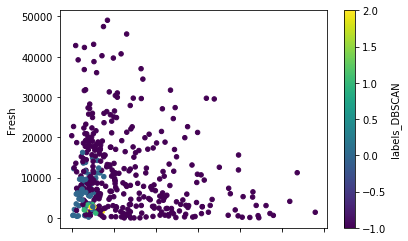

In [27]:
# Your code here:
customers.plot.scatter(x='Grocery', y='Fresh', c='Labels',colormap='viridis')
customers.plot.scatter(x='Grocery', y='Fresh', c='labels_DBSCAN',colormap='viridis')

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

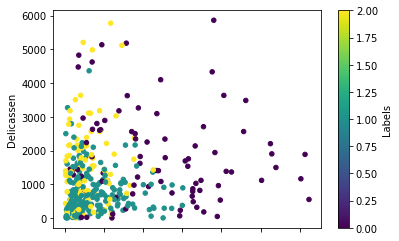

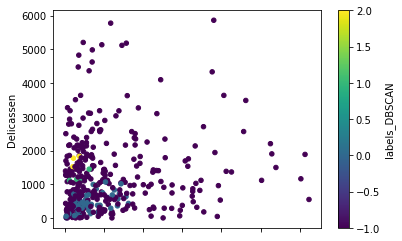

In [28]:
# Your code here:
customers.plot.scatter(x='Frozen', y='Delicassen', c='Labels',colormap='viridis')
customers.plot.scatter(x='Frozen', y='Delicassen', c='labels_DBSCAN',colormap='viridis')

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [29]:
# Your code here:
display(customers.groupby('Labels').mean())
customers.groupby('labels_DBSCAN').mean()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels_DBSCAN
Labels,,,,,,,,,
0,1.073171,2.621951,21992.902439,4331.817073,4287.073171,6089.573171,623.158537,1849.963415,-1.00000
1,1.019512,2.463415,8201.224390,2472.185366,3273.707317,1801.219512,741.853659,771.956098,-0.62439
2,1.954128,2.678899,7513.027523,8547.944954,13063.522936,1308.174312,5379.348624,1430.376147,-1.00000


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Labels
labels_DBSCAN,,,,,,,,,
-1,1.343373,2.46988,11743.515060,5122.813253,7026.114458,2772.183735,2310.015060,1293.240964,1.081325
0,1.000000,3.00000,7014.272727,1213.309091,1686.327273,1500.436364,334.236364,435.272727,1.000000
1,1.000000,3.00000,2134.600000,2943.800000,2104.800000,1097.800000,340.600000,1157.400000,1.000000
2,1.000000,3.00000,2071.000000,2877.000000,2658.000000,702.000000,629.250000,1694.000000,1.000000


# Bonus Challenge 2 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

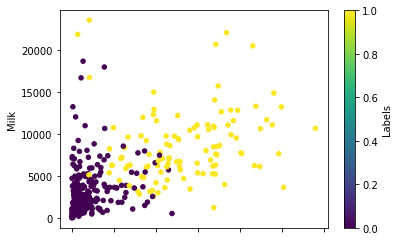

In [32]:
# Your code here
kmeans = KMeans(n_clusters=2, random_state=0).fit(customers_scales)
customers['Labels']=kmeans.labels_

customers.plot.scatter(x='Detergents_Paper', y='Milk', c='Labels',colormap='viridis')

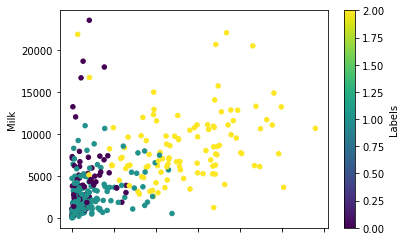

In [33]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(customers_scales)
customers['Labels']=kmeans.labels_

customers.plot.scatter(x='Detergents_Paper', y='Milk', c='Labels',colormap='viridis')

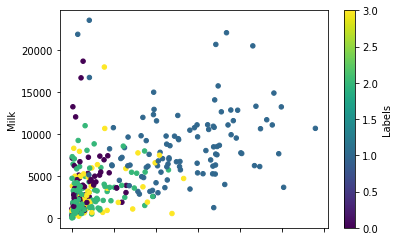

In [34]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(customers_scales)
customers['Labels']=kmeans.labels_

customers.plot.scatter(x='Detergents_Paper', y='Milk', c='Labels',colormap='viridis')

#Your comment here

Parece que la opción con 3 cluster es mejor

# Bonus Challenge 3 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

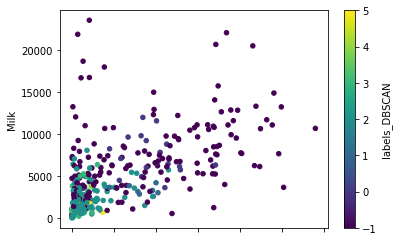

In [36]:
# Your code here
clustering = DBSCAN(eps=1).fit(customers_scales)
customers['labels_DBSCAN']=clustering.labels_
customers.plot.scatter(x='Detergents_Paper', y='Milk', c='labels_DBSCAN',colormap='viridis')

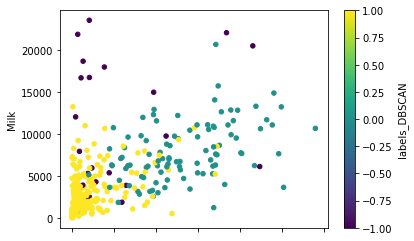

In [39]:
clustering = DBSCAN(eps=2).fit(customers_scales)
customers['labels_DBSCAN']=clustering.labels_
customers.plot.scatter(x='Detergents_Paper', y='Milk', c='labels_DBSCAN',colormap='viridis')

In [ ]:
# Your comment here